In [ ]:
import torch

In [2]:
import matplotlib.pyplot as plt
from ehc_sn import utils
from ehc_sn.data import cognitive_maps, obstacle_maps
from ehc_sn.models import autoencoders as models, encoders, decoders
from pydantic import BaseModel, Field

In [3]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

In [4]:
class Parameters(BaseModel):
    model_config = {"extra": "forbid"}  # Forbid extra fields not defined in the model
    encoder: encoders.EncoderParams = Field(
        description="Parameters for the encoder",
        default_factory=lambda: encoders.EncoderParams(
            input_shape=(1, 16, 32),  # 1 channel
            latent_dim=256,
        ),
    )
    decoder: decoders.DecoderParams = Field(
        description="Parameters for the decoder",
        default_factory=lambda: decoders.DecoderParams(
            input_shape=(1, 16, 32),  # 1 channel
            latent_dim=256,
        ),
    )


params = Parameters()

# Generate a model instance
encoder = encoders.LinearEncoder(params.encoder)
decoder = decoders.LinearDecoder(params.decoder)
model = models.Autoencoder(encoder, decoder)
model.eval()

Autoencoder(
  (encoder): LinearEncoder(
    (linear): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): GELU(approximate='none')
    )
  )
  (decoder): LinearDecoder(
    (linear): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): Sigmoid()
    )
  )
)

In [ ]:
# Load checkpoint
path = "logs/autoencoder/version_1/checkpoints/epoch=199-step=20000.ckpt"

# Extract model state dict
utils.load_weights(model, path, map_location="cpu")

In [6]:
model

Autoencoder(
  (encoder): LinearEncoder(
    (linear): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): GELU(approximate='none')
    )
  )
  (decoder): LinearDecoder(
    (linear): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): Sigmoid()
    )
  )
)

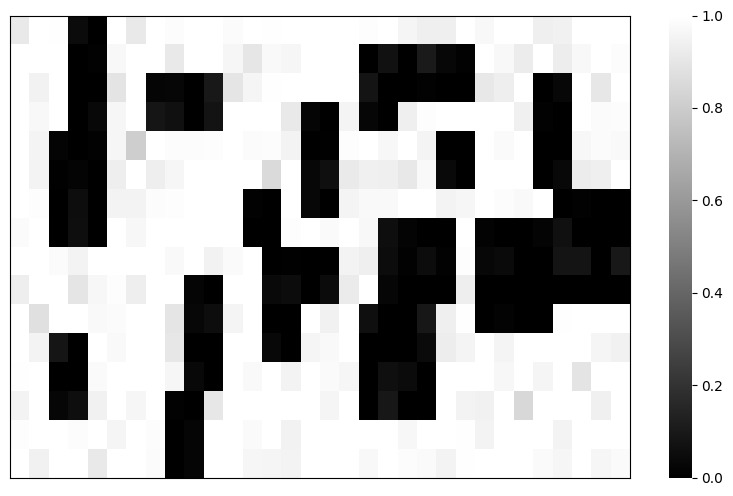

In [7]:
maps_params = cognitive_maps.BlockMapParams(grid_size=(16, 32), seed=42)
maps_params.diffusion_iterations = 0
maps_generator = cognitive_maps.BlockMapGenerator(maps_params)
maps_datamodule = obstacle_maps.DataModule(maps_generator)
maps_datamodule.setup()
maps, *_ = next(iter(maps_datamodule.train_dataloader()))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_params = cognitive_maps.PlotMapParams()
cognitive_maps.plot([ax], maps[0], plot_params)
plt.show()

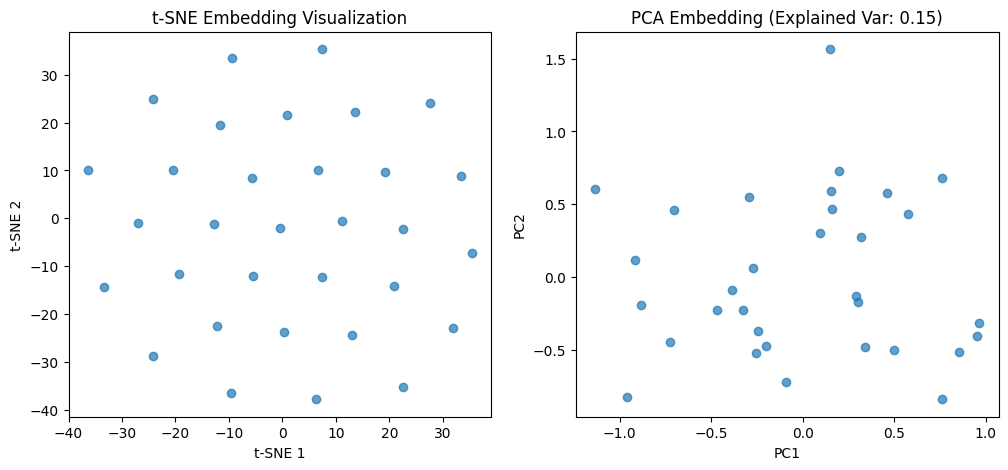

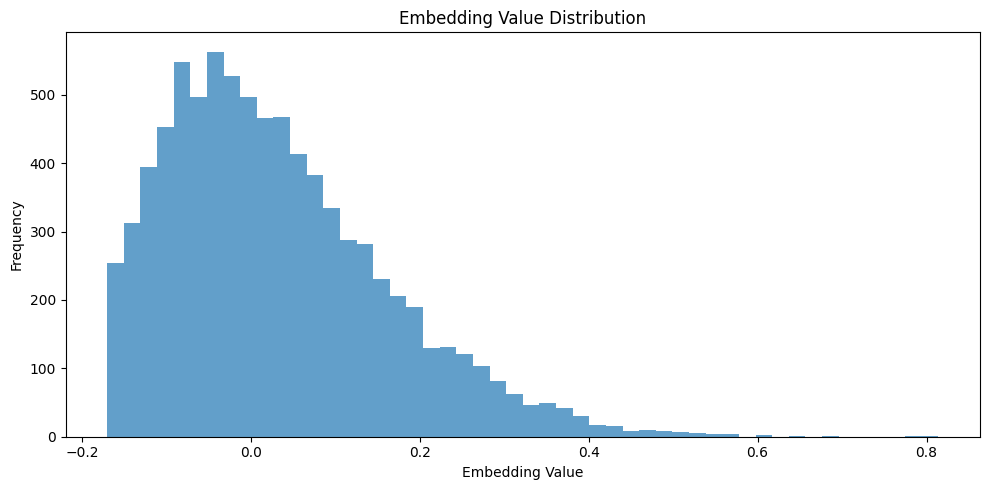

In [8]:
# Get reconstructions from the model
model.eval()
with torch.no_grad():
    embeddings = model.encoder(maps)
embeddings_np = embeddings.detach().numpy()

# Method 1: t-SNE and PCA (linear dimensionality reduction)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings_np)-1))
embeddings_2d = tsne.fit_transform(embeddings_np)
axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
axes[0].set_title('t-SNE Embedding Visualization')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_np)
axes[1].scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.7)
axes[1].set_title(f'PCA Embedding (Explained Var: {pca.explained_variance_ratio_.sum():.2f})')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

# Method 2: Embedding distribution histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(embeddings_np.flatten(), bins=50, alpha=0.7)
ax.set_title('Embedding Value Distribution')
ax.set_xlabel('Embedding Value')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

tensor([[-0.0241, -0.0327,  0.2788,  ..., -0.0842,  0.0308, -0.0131],
        [ 0.1845,  0.0336, -0.0227,  ...,  0.0696, -0.0282, -0.0205],
        [-0.1347,  0.0220,  0.1012,  ...,  0.1085,  0.0918, -0.0807],
        ...,
        [ 0.1131,  0.1484,  0.0726,  ...,  0.0562,  0.3202, -0.0426],
        [-0.1594,  0.2468,  0.0829,  ...,  0.0684,  0.1732, -0.0775],
        [ 0.0934,  0.0332, -0.1309,  ..., -0.0281,  0.1135,  0.2066]])


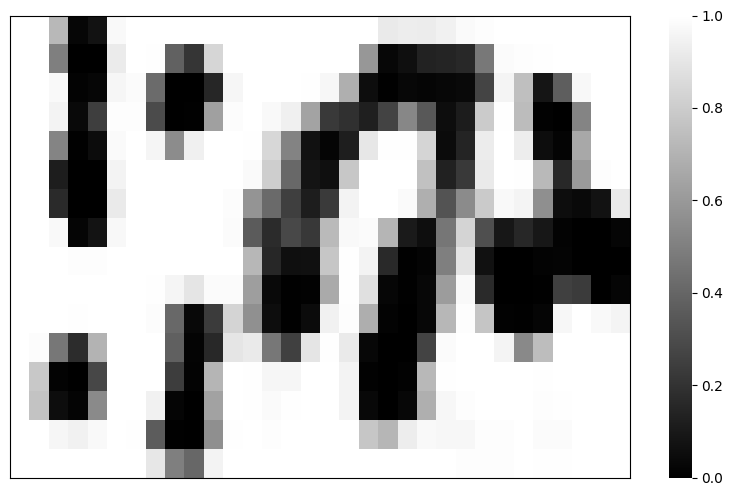

In [9]:
model.eval()
with torch.no_grad():
    reconstructions = model.decoder(embeddings)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_params = cognitive_maps.PlotMapParams()
cognitive_maps.plot([ax], reconstructions[0], plot_params)
print(embeddings)
plt.show()

In [10]:
embeddings.shape

torch.Size([32, 256])

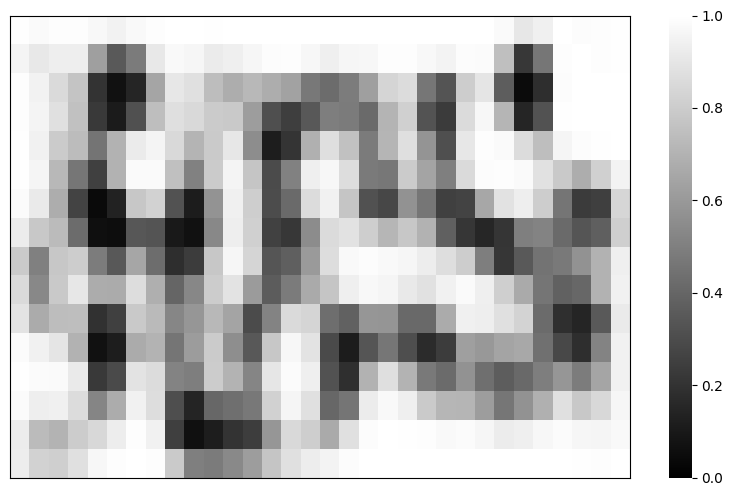

In [11]:
model.eval()
with torch.no_grad():
    embeddings = torch.zeros((1, 256))  # Example embedding
    embeddings[0, 0] = 1.0  # Set the first dimension to 1.0
    reconstructions = model.decoder(embeddings)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_params = cognitive_maps.PlotMapParams()
cognitive_maps.plot([ax], reconstructions[0], plot_params)
plt.show()